In [0]:
import sys
import torch  
import gym
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
from tqdm import tqdm

In [0]:
# Constants
GAMMA = 0.99

class PolicyNetwork(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, learning_rate=3e-4):
        super(PolicyNetwork, self).__init__()

        self.num_actions = num_actions
        self.linear1 = nn.Linear(num_inputs, hidden_size)
        self.linear2 = nn.Linear(hidden_size, num_actions)
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)

    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = F.softmax(self.linear2(x), dim=1)
        return x 
    
    def get_action(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0)
        probs = self.forward(Variable(state))
        #Choose action with regard to policy
        highest_prob_action = np.random.choice(self.num_actions, p=np.squeeze(probs.detach().numpy()))
        log_prob = torch.log(probs.squeeze(0)[highest_prob_action]) #log for gradient
        return highest_prob_action, log_prob

In [0]:
def update_policy(policy_network, trajectories_gradient):
    policy_network.optimizer.zero_grad()
    policy_gradient = torch.stack(trajectories_gradient).sum()
    policy_gradient.backward()
    policy_network.optimizer.step()

In [0]:
def count_trajectory(rewards, log_probs):
    discounted_rewards = []

    for t in range(len(rewards)):
        Gt = 0 
        pw = 0
        for r in rewards[t:]:
            Gt = Gt + GAMMA**pw * r
            pw = pw + 1
        discounted_rewards.append(Gt)
        
    discounted_rewards = torch.tensor(discounted_rewards)
    discounted_rewards = (discounted_rewards - discounted_rewards.mean()) / (discounted_rewards.std() + 1e-9) # normalize discounted rewards

    policy_gradient = []
    for log_prob, Gt in zip(log_probs, discounted_rewards):
        policy_gradient.append(-log_prob * Gt)
    
    policy_gradient = torch.stack(policy_gradient).sum()
    return policy_gradient

In [0]:
def align_columns_zeros(array):
    max_length = max(list(map(lambda x: len(x), array)))
    for col in range(len(array)):
        array[col] = np.pad(array[col], max_length - len(array[col]), 'constant', constant_values = 0)[max_length - len(array[col]):]
    return array

In [0]:
def cart_pole(n_trajectories = 2, episode_num = 1500):
    env = gym.make('CartPole-v0')
    policy_net = PolicyNetwork(env.observation_space.shape[0], env.action_space.n, 256)

    max_episode_num = episode_num
    max_steps = 10000
    numsteps = [[] for i in range(n_trajectories)]
    avg_numsteps = [[] for i in range(n_trajectories)]
    all_rewards = [[] for i in range(n_trajectories)]

    for episode in range(max_episode_num):
        r_gradient = []
        rewards = [[] for i in range(n_trajectories)]
        
        for trajectory in range(n_trajectories):
            state = env.reset()
            log_probs = []
            
            for steps in range(max_steps):
                #env.render()
                action, log_prob = policy_net.get_action(state)
                new_state, reward, done, _ = env.step(action)
                log_probs.append(log_prob)
                rewards[trajectory].append(reward)
                
                if done:
                    traj = count_trajectory(rewards[trajectory], log_probs)                       
                    r_gradient.append(traj)
                    numsteps[trajectory].append(steps)
                    avg_numsteps[trajectory].append(np.mean(numsteps[trajectory][-10:]))
                    all_rewards[trajectory].append(np.sum(rewards[trajectory]))
                    break

                state = new_state
                
        #print('Updating...')
        update_policy(policy_net, r_gradient)                 
        rewards = align_columns_zeros(rewards)
        #print(all_rewards)
        if episode % 10 == 0:
            sys.stdout.write("episode: {}, total mean reward among trajectories: {}, average reward among trajectories: {}\n".\
                                     format(episode, np.round(np.mean(np.sum(rewards, axis = 1)), decimals = 3),\
                                            np.round(np.mean(np.mean(all_rewards, axis = 0)[-10:]), decimals = 3)))
        
    return all_rewards, avg_numsteps 

**1 Trajectory**

In [0]:
%%time
statistics_all = []
statistics_mean = []
for game in tqdm(range(10)):
  all_rewards, mean_rewards = cart_pole(1, 2000)
  statistics_all.append(all_rewards)
  statistics_mean.append(mean_rewards)

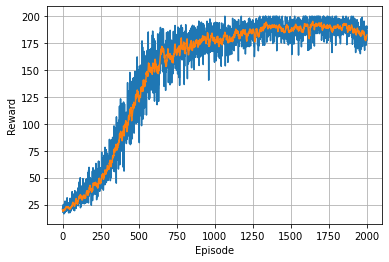

Varince of reward = 3195.2906753775


In [0]:
plt.plot(np.mean(np.mean(statistics_all, axis = 1), axis = 0))
plt.plot(np.mean(np.mean(statistics_mean, axis = 1), axis = 0))
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.grid()
plt.show()
print('Varince of reward = {}'.format(np.var(np.mean(np.mean(statistics_all, axis = 1), axis = 0))))

**2 Trajectories**


In [0]:
%%time
statistics_all = []
statistics_mean = []
for game in tqdm(range(10)):
  all_rewards, mean_rewards = cart_pole(2, 2000)
  statistics_all.append(all_rewards)
  statistics_mean.append(mean_rewards)

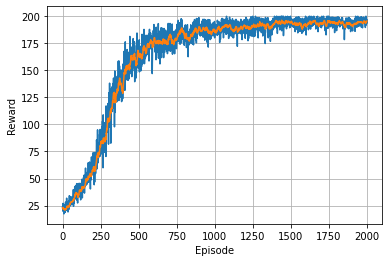

Varince of reward = 2566.3131723774995


In [0]:
plt.plot(np.mean(np.mean(statistics_all, axis = 1), axis = 0))
plt.plot(np.mean(np.mean(statistics_mean, axis = 1), axis = 0))
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.grid()
plt.show()
print('Varince of reward = {}'.format(np.var(np.mean(np.mean(statistics_all, axis = 1), axis = 0))))